In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb

In [6]:
df=pd.read_csv('./toyota.csv')


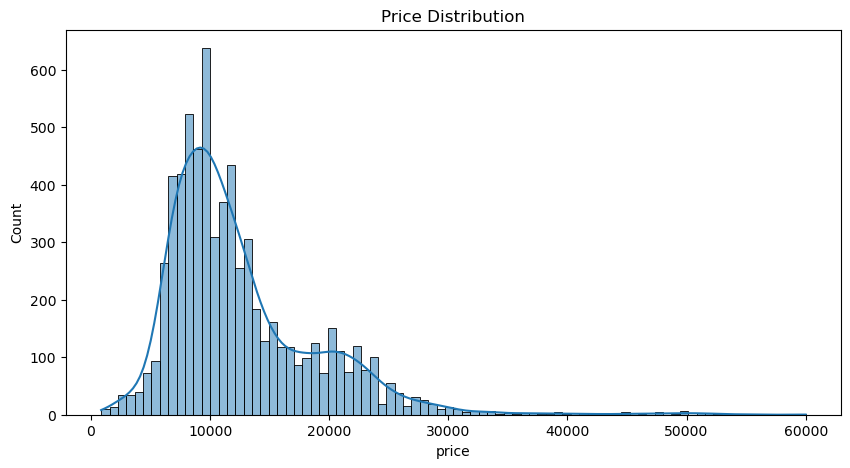

In [7]:
# Price distribution
plt.figure(figsize=(10,5))
sns.histplot(df['price'], kde=True)
plt.title('Price Distribution')
plt.show()

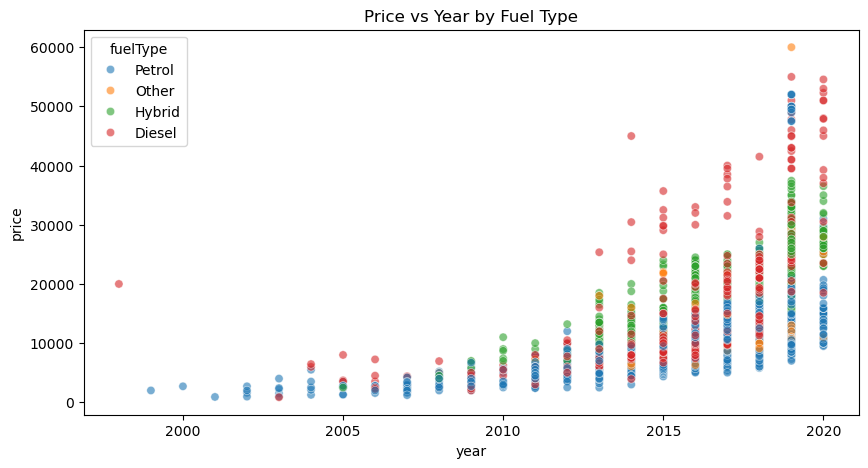

In [8]:
# Price vs Year
plt.figure(figsize=(10,5))
sns.scatterplot(data=df, x='year', y='price', hue='fuelType', alpha=0.6)
plt.title('Price vs Year by Fuel Type')
plt.show()

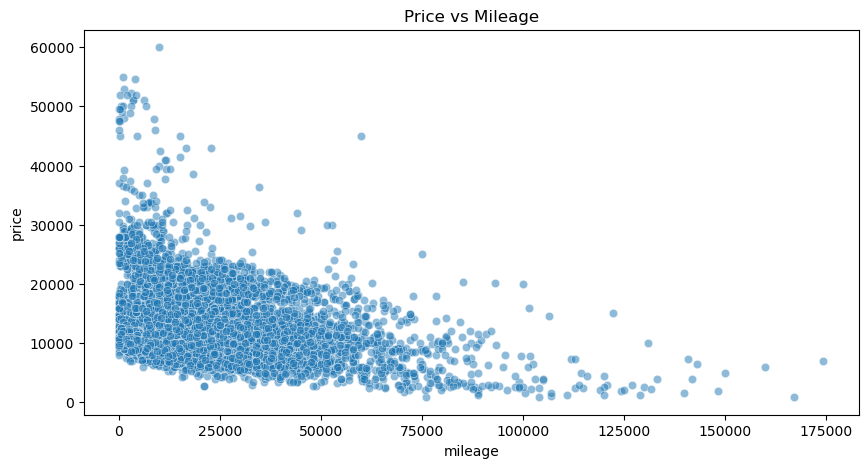

In [9]:
# Price vs Mileage
plt.figure(figsize=(10,5))
sns.scatterplot(data=df, x='mileage', y='price', alpha=0.5)
plt.title('Price vs Mileage')
plt.show()

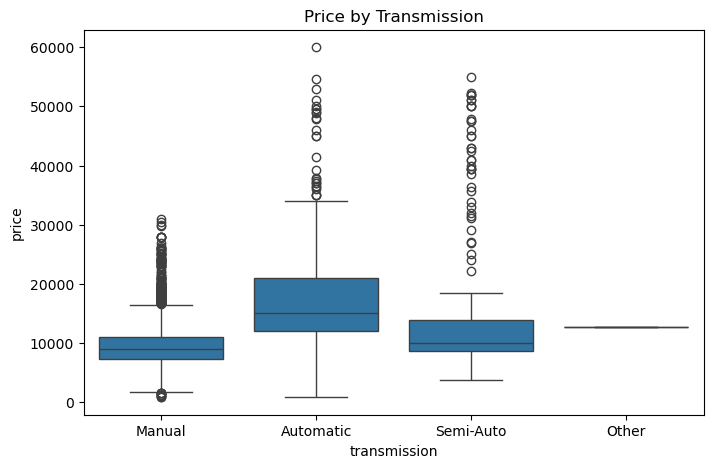

In [10]:
# Boxplot – transmission & price
plt.figure(figsize=(8,5))
sns.boxplot(data=df, x='transmission', y='price')
plt.title('Price by Transmission')
plt.show()

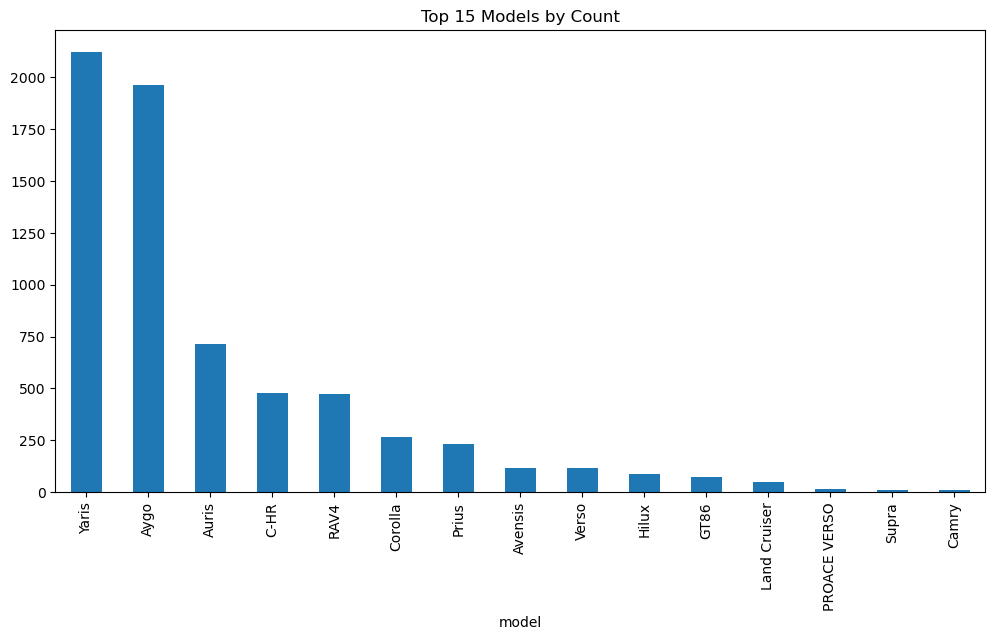

In [11]:
# Most common models
plt.figure(figsize=(12,6))
df['model'].value_counts().head(15).plot(kind='bar')
plt.title('Top 15 Models by Count')
plt.show()

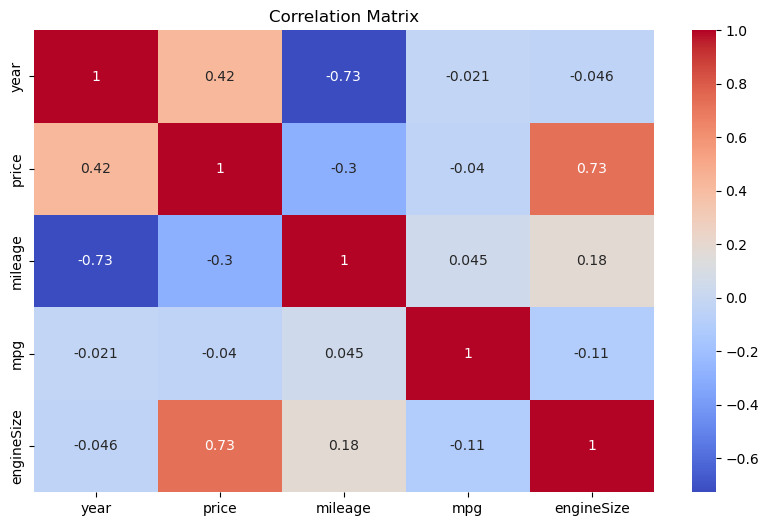

In [21]:
correlation_matrix = df.select_dtypes(include='number').corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

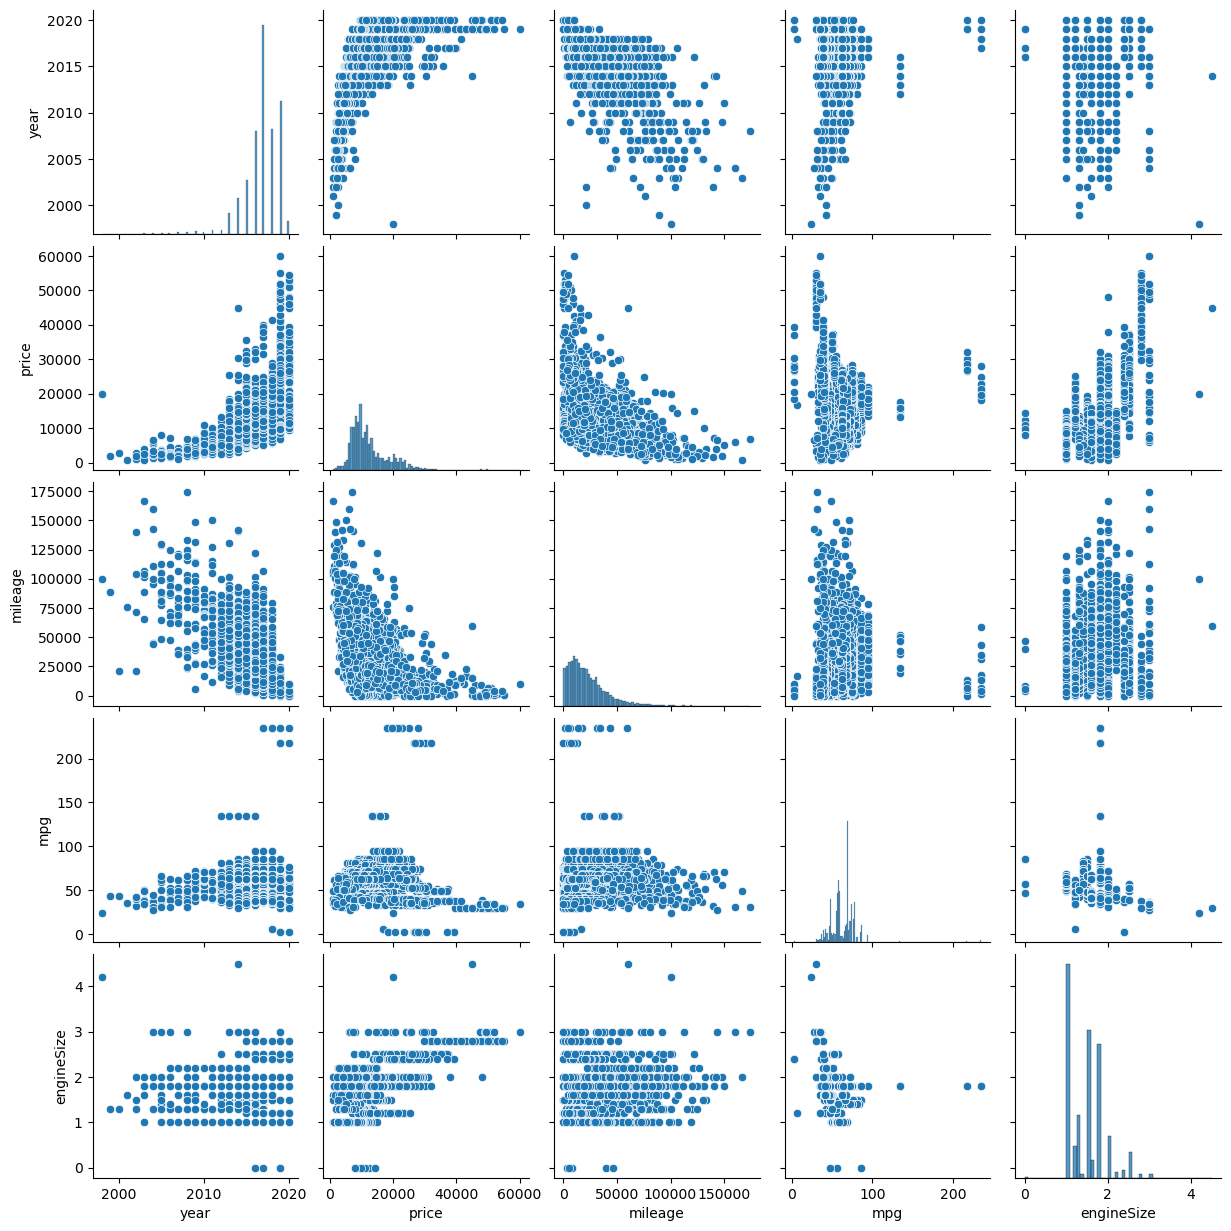

In [20]:
# Create a pair plot
sns.pairplot(df)

# Show the plot
plt.show()

In [13]:
# Features to use
categorical_features = ['model', 'transmission', 'fuelType']
numerical_features   = ['year', 'mileage', 'mpg', 'engineSize']

X = df[categorical_features + numerical_features]
y = df['price']

In [14]:
# TRAIN-TEST SPLIT
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

print("Train shape:", X_train.shape)
print("Test shape :", X_test.shape)

Train shape: (5390, 7)
Test shape : (1348, 7)


In [15]:
# LINEAR REGRESSION

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_features),
        ('num', 'passthrough', numerical_features)
    ])

lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Fit
lr_pipeline.fit(X_train, y_train)

# Predict & Evaluate
y_pred_lr = lr_pipeline.predict(X_test)

rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr   = r2_score(y_test, y_pred_lr)

print("\nLinear Regression")
print(f"RMSE: {rmse_lr:,.0f}")
print(f"R²:   {r2_lr:.4f}")



Linear Regression
RMSE: 2,082
R²:   0.8981


In [16]:
# XGBOOST with Grid Search

xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', xgb.XGBRegressor(
        objective='reg:squarederror',
        random_state=42,
        n_jobs=-1
    ))
])

# Parameter grid (moderate size – you can expand)
param_grid = {
    'regressor__n_estimators':    [200, 400],
    'regressor__max_depth':       [4, 6, 8],
    'regressor__learning_rate':   [0.05, 0.1],
    'regressor__subsample':       [0.8, 1.0],
    'regressor__colsample_bytree':[0.8, 1.0]
}

grid = GridSearchCV(
    xgb_pipeline,
    param_grid,
    cv=3,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)

print("\nBest parameters:")
print(grid.best_params_)
print(f"Best CV RMSE: {-grid.best_score_:,.0f}")

Fitting 3 folds for each of 48 candidates, totalling 144 fits

Best parameters:
{'regressor__colsample_bytree': 0.8, 'regressor__learning_rate': 0.05, 'regressor__max_depth': 6, 'regressor__n_estimators': 200, 'regressor__subsample': 1.0}
Best CV RMSE: 1,207


In [17]:
# Final model
best_model = grid.best_estimator_

# Predict on test set
y_pred_xgb = best_model.predict(X_test)

rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb   = r2_score(y_test, y_pred_xgb)

print("\nBest XGBoost")
print(f"RMSE: {rmse_xgb:,.0f}")
print(f"R²:   {r2_xgb:.4f}")




Best XGBoost
RMSE: 1,083
R²:   0.9724


In [18]:
# COMPARE PREDICTIONS (sample)

comparison = pd.DataFrame({
    'Actual': y_test,
    'LinearReg': y_pred_lr.round(0).astype(int),
    'XGBoost': y_pred_xgb.round(0).astype(int)
}).reset_index(drop=True)

print("\nSample predictions:")
display(comparison.sample(15))



Sample predictions:


,Actual,LinearReg,XGBoost
484,10999,11099,10244
1090,11220,12263,10478
951,7498,7102,7622
380,9930,10731,9913
147,950,-4997,1449
60,9999,8929,10212
622,5475,4509,5857
1082,6500,3278,5525
143,29980,24861,31906
690,12631,14021,12626
